In [1]:
# import necessary libraries

import math
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn import set_config
set_config(display='diagram')  # To visualize pipelines better

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, PrecisionRecallDisplay
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
from sklearn.base import BaseEstimator, TransformerMixin


# Data Load

In [2]:
# Read the dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Display basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# data type conversions and handling missing values

data.drop('customerID', axis=1, inplace=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)
data['SeniorCitizen'] = data['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
data['Churn'] = data['Churn'].replace({'No': 0, 'Yes': 1})

In [5]:
# Identify categorical and numerical features

cat_features = data.select_dtypes(include=['object']).columns.tolist()
num_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", cat_features)
print("Numerical Features:", num_features)

Categorical Features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


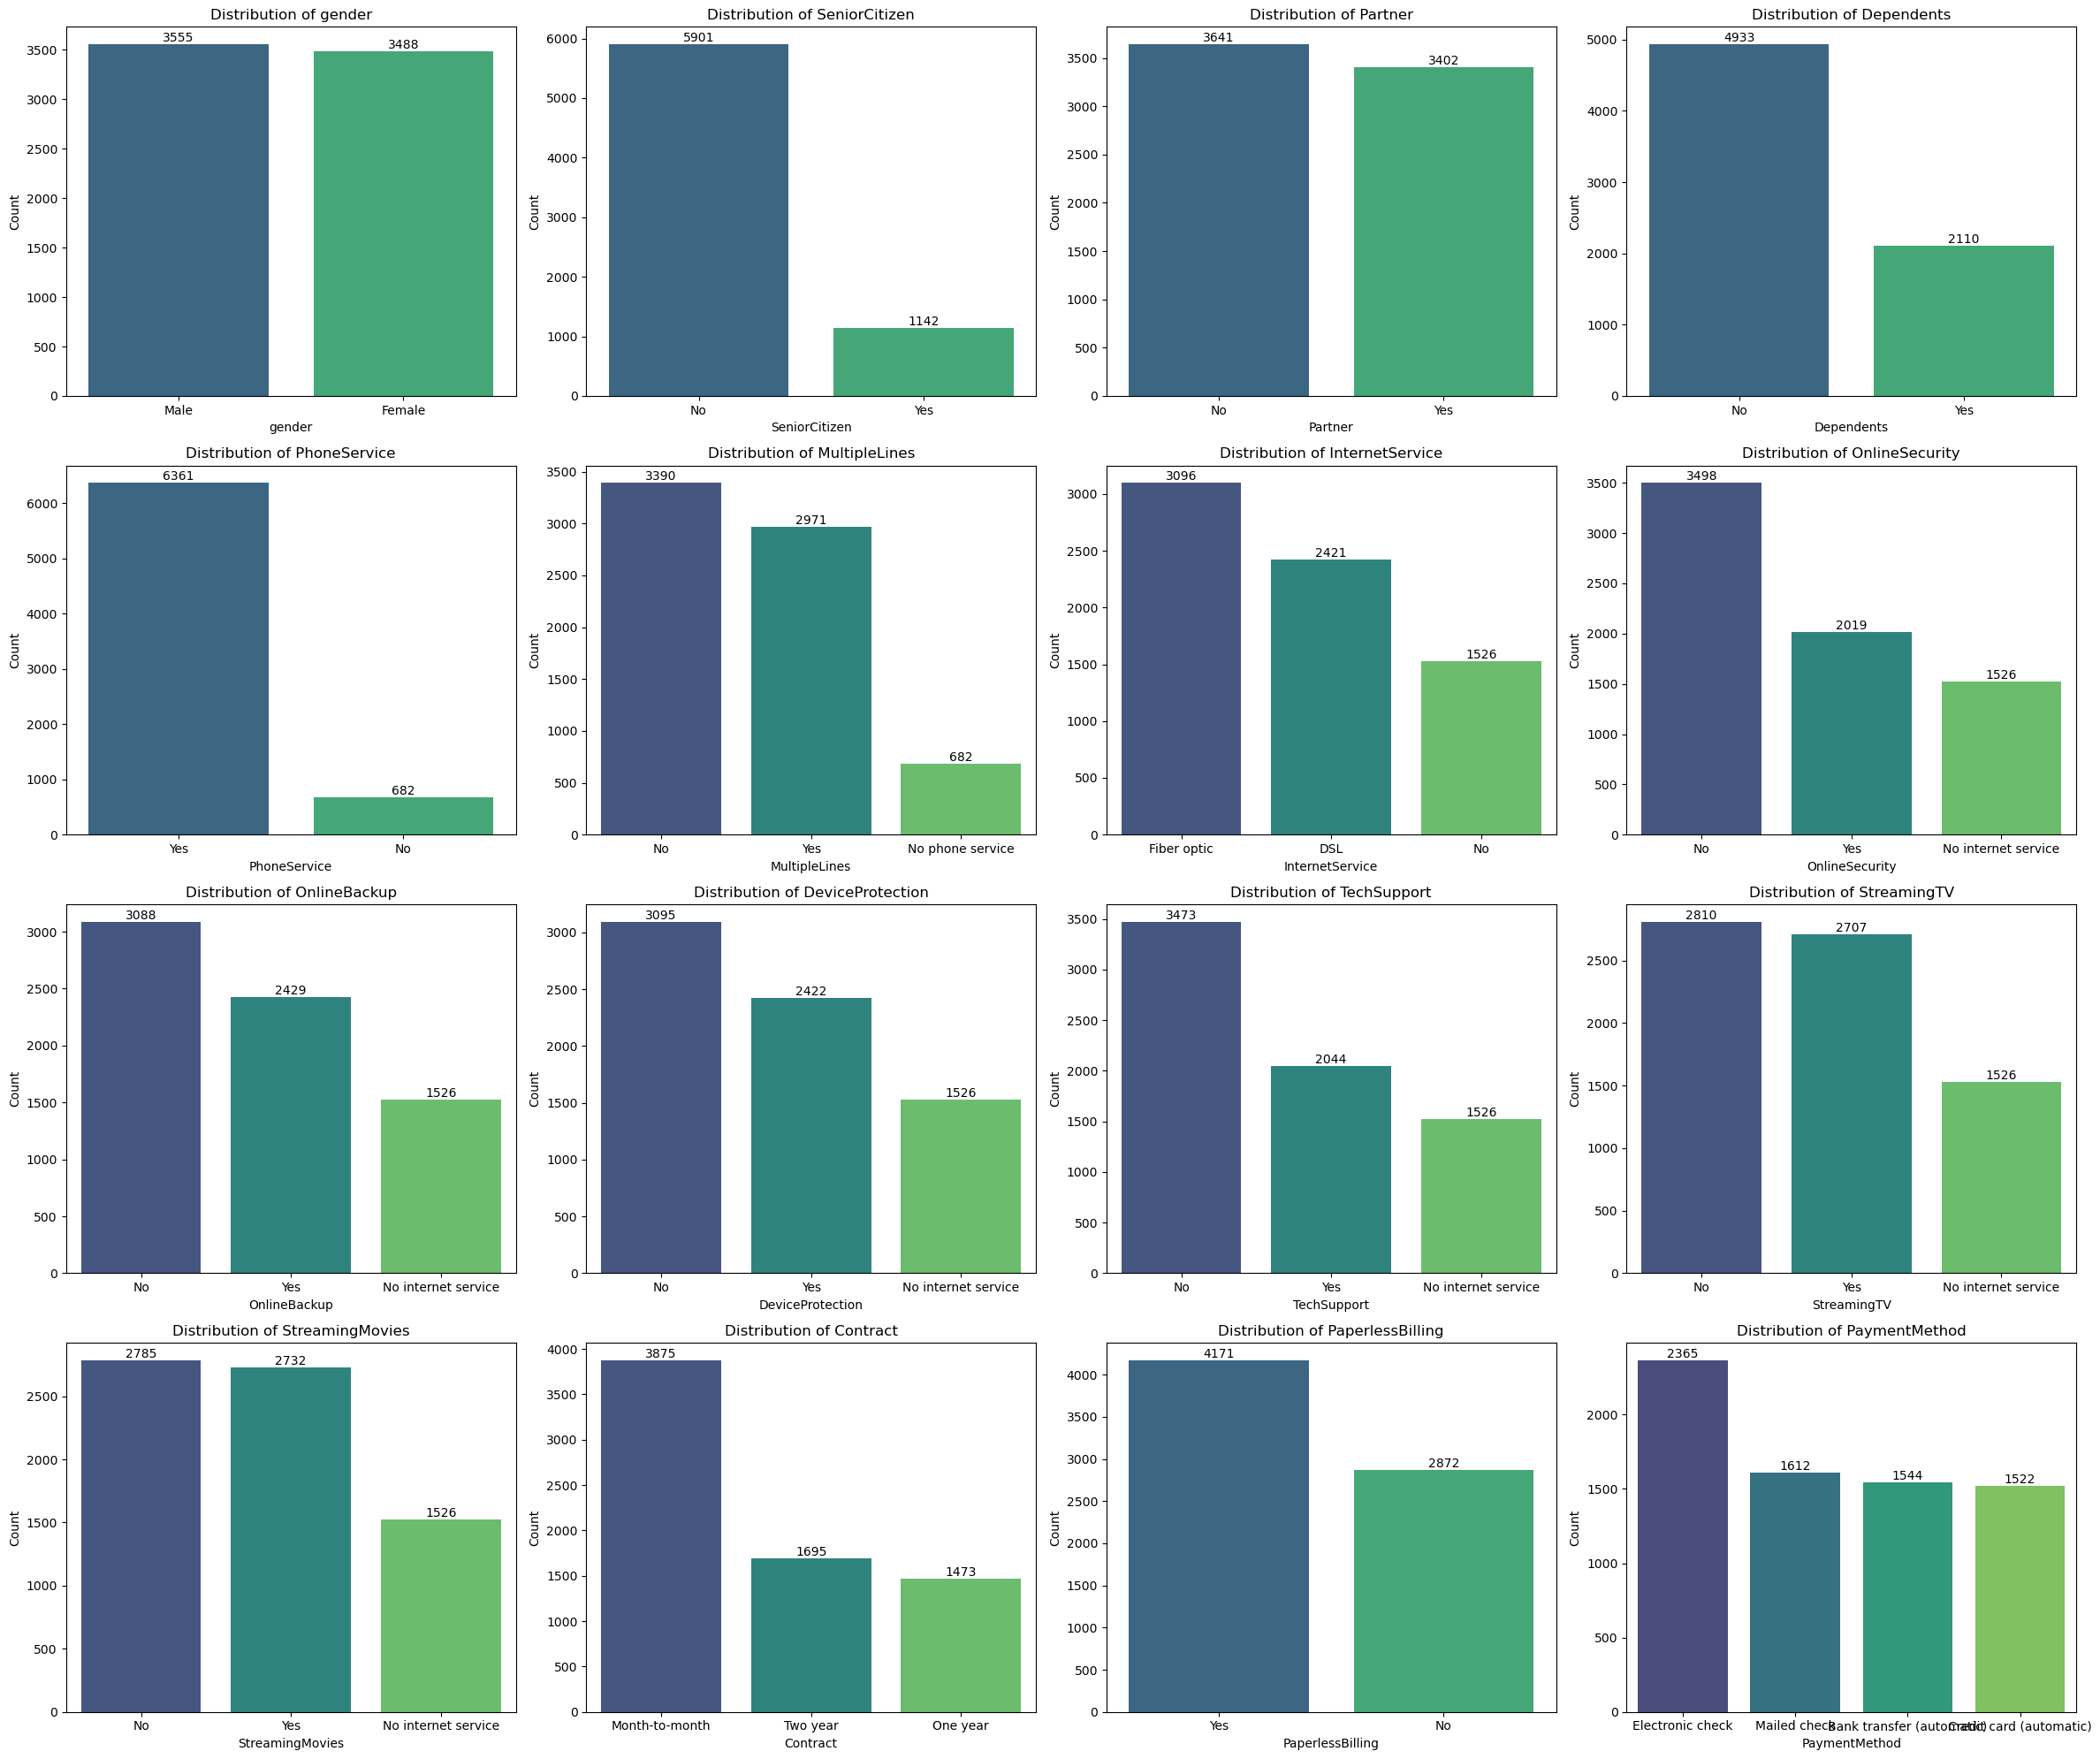

In [6]:
# Visualize categorical feature distributions

ncols = 4
num_rows = math.ceil(len(cat_features) / ncols) 

plt.figure(figsize=(24, 5 * num_rows)) 

for i, col in enumerate(cat_features):
    plt.subplot(num_rows, ncols, i + 1) 

    sns.countplot(x=col, data=data, palette='viridis', order=data[col].value_counts().index)
    
    plt.title(f'Distribution of {col}') 
    plt.xlabel(col)
    plt.ylabel('Count')
    
    for container in plt.gca().containers:
        plt.gca().bar_label(container)

plt.tight_layout() 
plt.show()

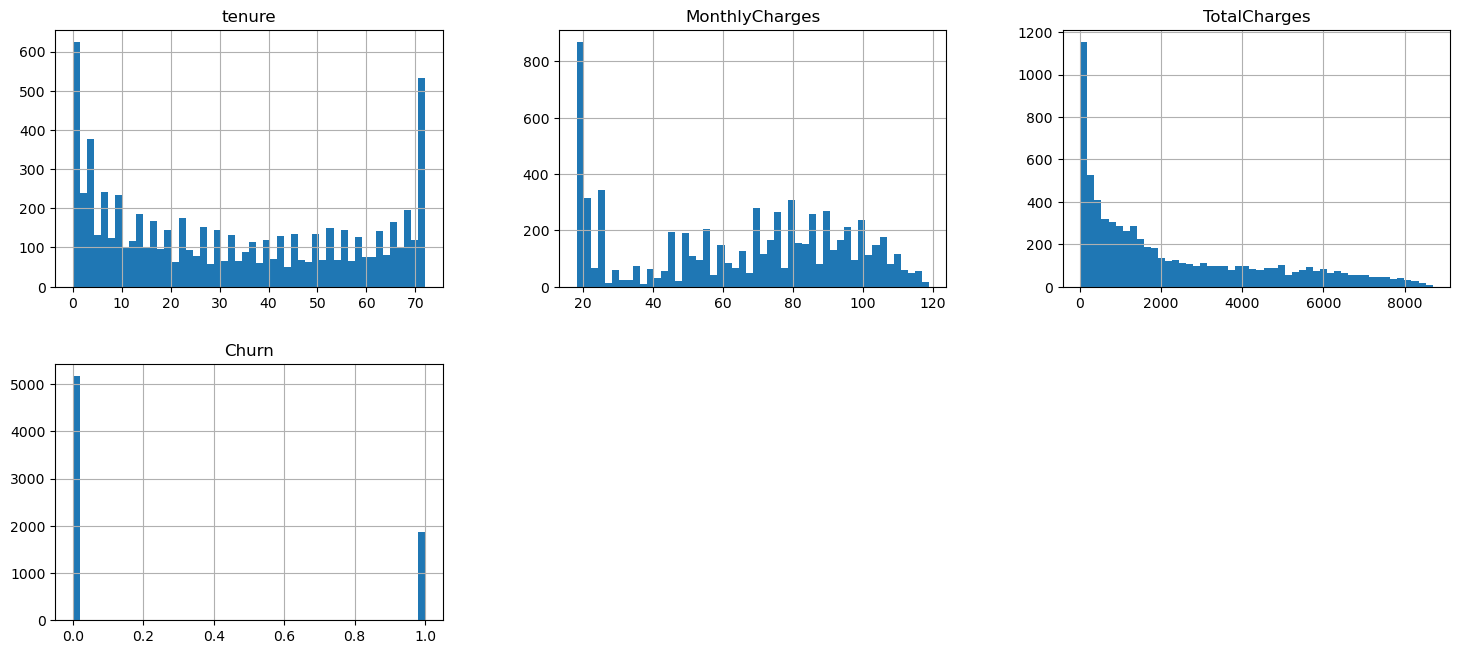

In [8]:
# Visualize numerical feature distributions

data.hist(bins=50, figsize=(18, 12), layout=(3, 3))
plt.show()

In [9]:
# Split the dataset into training and testing sets with stratification
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Churn'], random_state=42)
print(f'Training set size: {train_data.shape}')
print(f'Testing set size: {test_data.shape}')

Training set size: (5634, 20)
Testing set size: (1409, 20)


In [10]:
# create a copy of the training data
data_copy = train_data.copy()

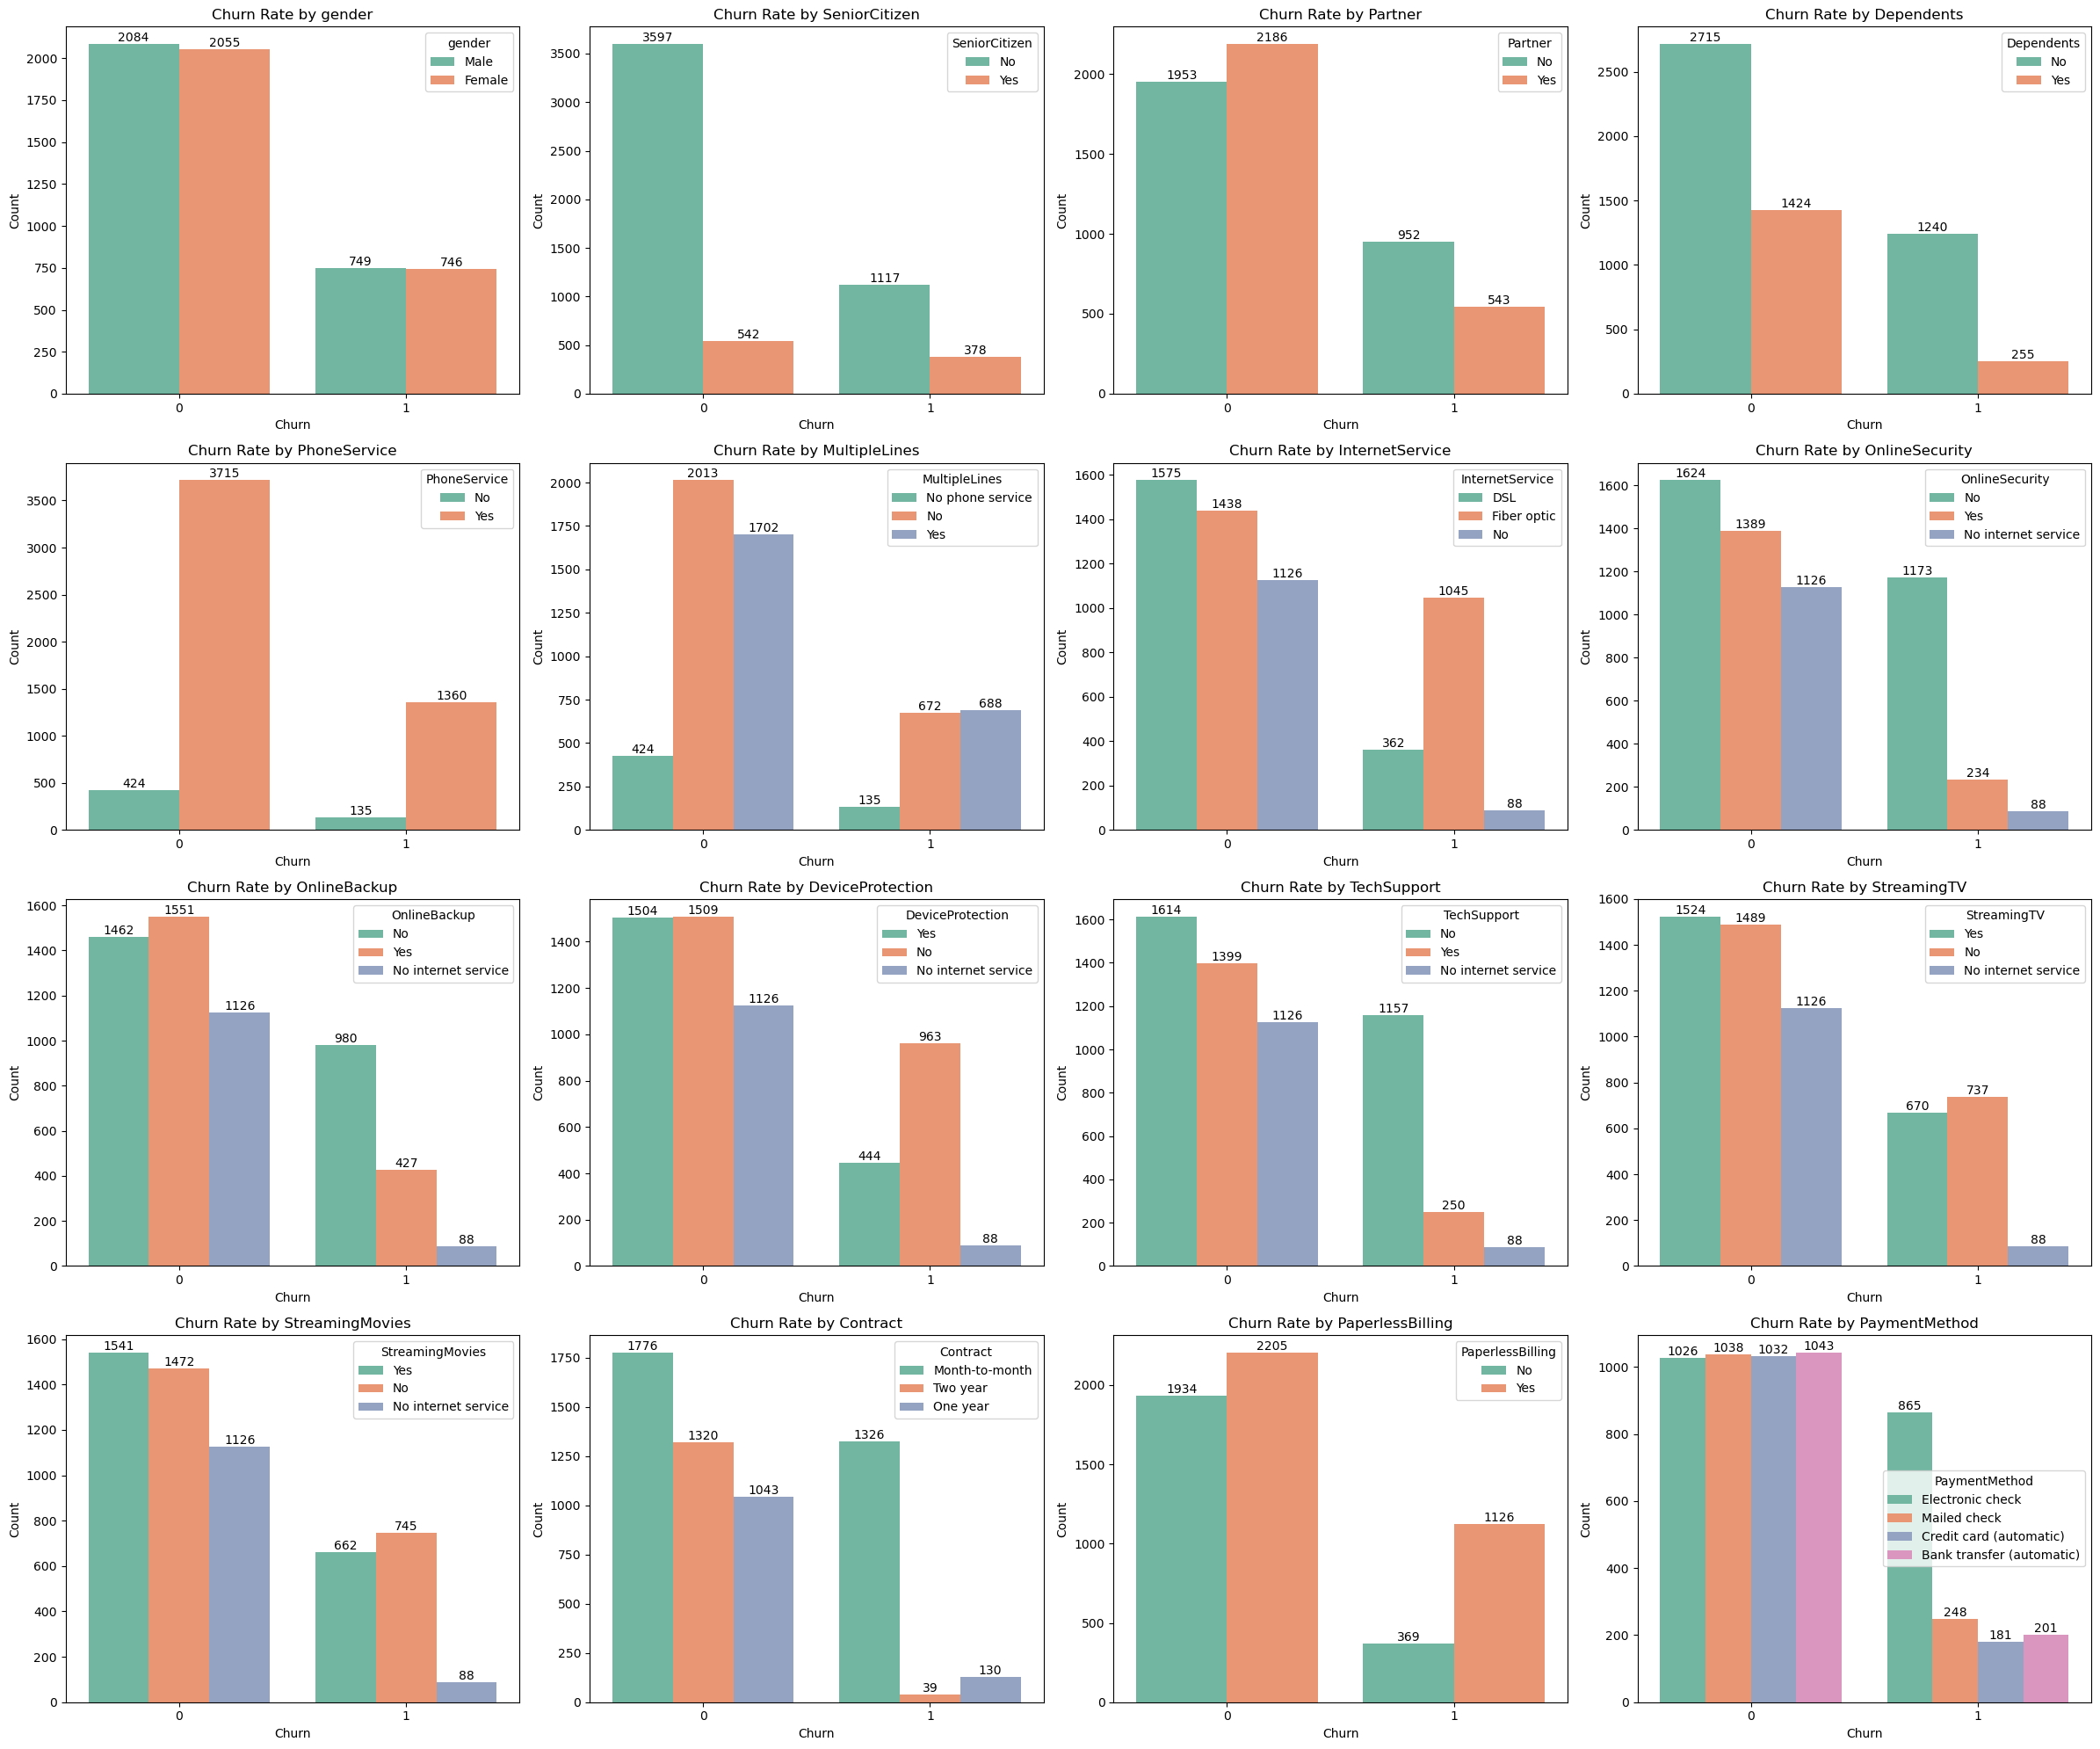

In [11]:
# Visualize categorical features against Churn

ncols = 4
num_rows = math.ceil(len(cat_features) / ncols) 

plt.figure(figsize=(24, 5 * num_rows)) 

for i, col in enumerate(cat_features):
    plt.subplot(num_rows, ncols, i + 1) 

    sns.countplot(x='Churn', hue=col, data=data_copy, palette='Set2', order=data_copy['Churn'].value_counts().index)
    
    plt.title(f'Churn Rate by {col}') 
    plt.xlabel('Churn')
    plt.ylabel('Count')
    
    for container in plt.gca().containers:
        plt.gca().bar_label(container)

plt.tight_layout() 
plt.show()

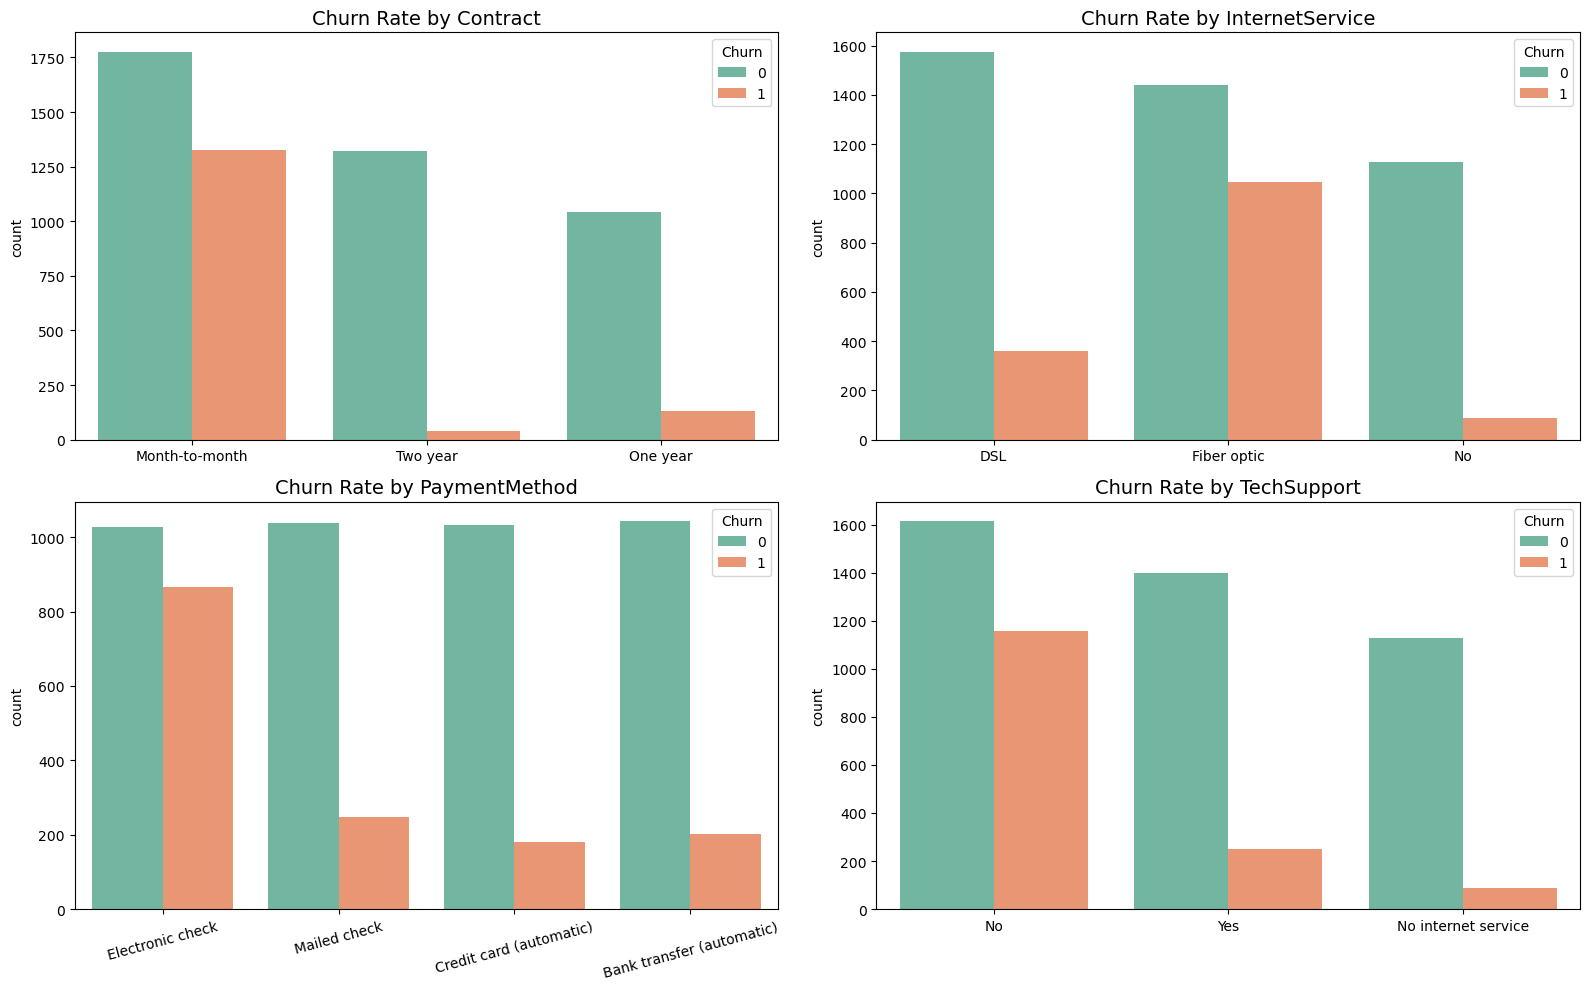

In [12]:
key_features = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for i, col in enumerate(key_features):
    row = i // 2
    col_idx = i % 2
    
    sns.countplot(x=col, hue='Churn', data=data_copy, ax=axes[row, col_idx], palette='Set2')
    
    axes[row, col_idx].set_title(f'Churn Rate by {col}', fontsize=14)
    axes[row, col_idx].set_xlabel('')
    
    if col == 'PaymentMethod':
        axes[row, col_idx].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

In [13]:
# Chi-square tests for independence between 'Churn' and selected categorical features

for feature in ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport']:
    chi2, p_value, dof, expected = chi2_contingency(pd.crosstab(data_copy['Churn'], data_copy[feature]))
    print("P-value for '{}' feature: {:.5f}".format(feature, p_value))
    if p_value < 0.05:
        print(">> Conclusion: Statistically significant difference between 'Churn' and '{}' exists.".format(feature))
    else:
        print(">> Conclusion: No statistically significant difference.")

P-value for 'Contract' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'Contract' exists.
P-value for 'InternetService' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'InternetService' exists.
P-value for 'PaymentMethod' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'PaymentMethod' exists.
P-value for 'TechSupport' feature: 0.00000
>> Conclusion: Statistically significant difference between 'Churn' and 'TechSupport' exists.


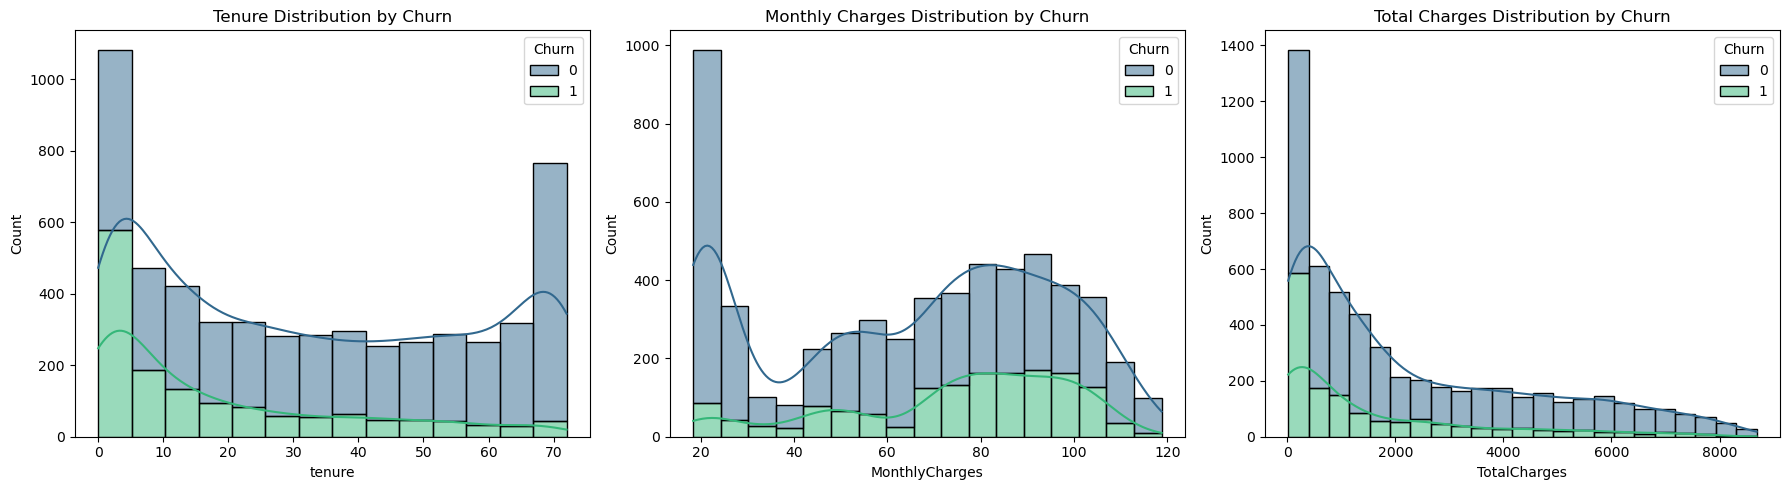

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. Tenure (가입 기간) - 이탈자(Yes)는 초기에 집중됨을 보여줌
sns.histplot(data=data_copy, x='tenure', hue='Churn', multiple='stack', kde=True, ax=ax[0], palette='viridis')
ax[0].set_title('Tenure Distribution by Churn')

# 2. MonthlyCharges (월 요금) - 이탈자(Yes)가 고요금 구간에 많음을 보여줌
sns.histplot(data=data_copy, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, ax=ax[1], palette='viridis')
ax[1].set_title('Monthly Charges Distribution by Churn')

# 3. TotalCharges (총 요금) - 로그 변환 필요성 시각화
sns.histplot(data=data_copy, x='TotalCharges', hue='Churn', multiple='stack', kde=True, ax=ax[2], palette='viridis')
ax[2].set_title('Total Charges Distribution by Churn')

plt.tight_layout()
plt.show()

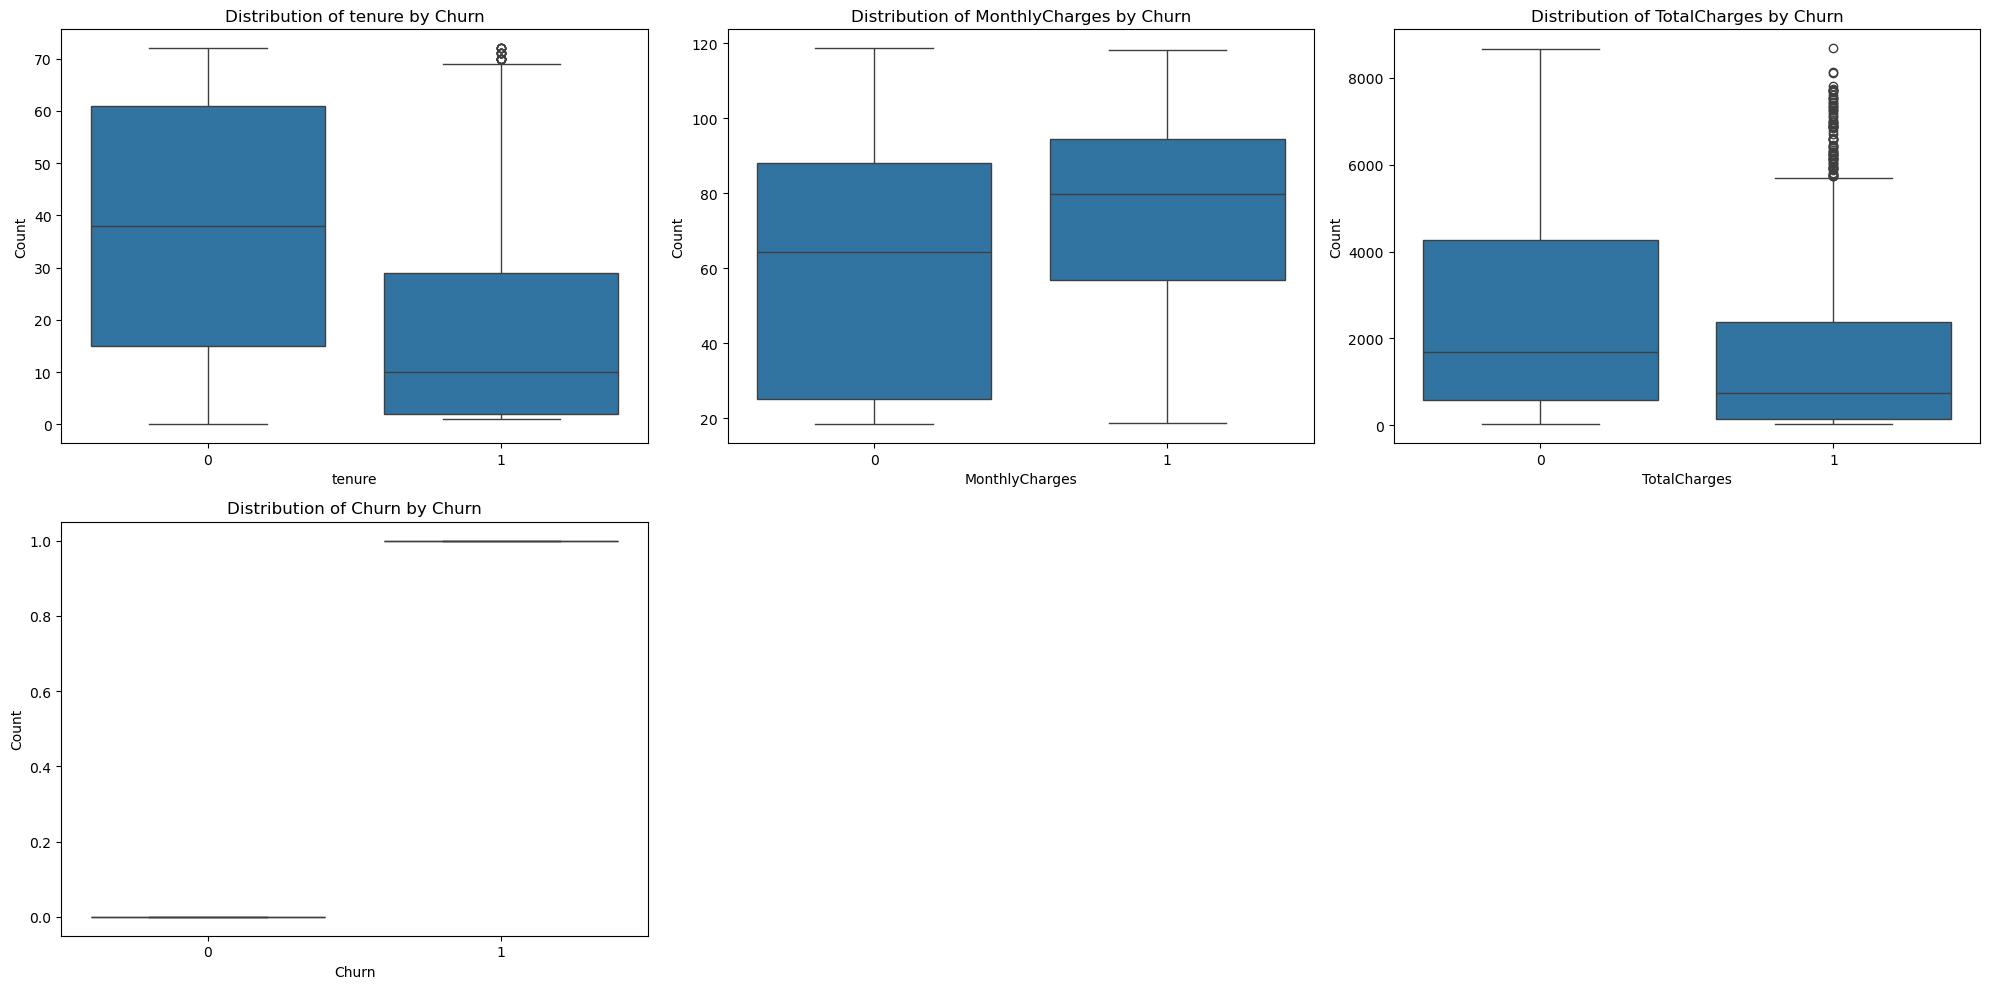

In [15]:
# Visualize numerical features against Churn

ncols = 3 
num_rows = math.ceil(len(num_features) / ncols)

plt.figure(figsize=(20, 5 * num_rows))

for i, col in enumerate(num_features):
    plt.subplot(num_rows, ncols, i + 1)
    sns.boxplot(x='Churn', y=col, data=data_copy)
    
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

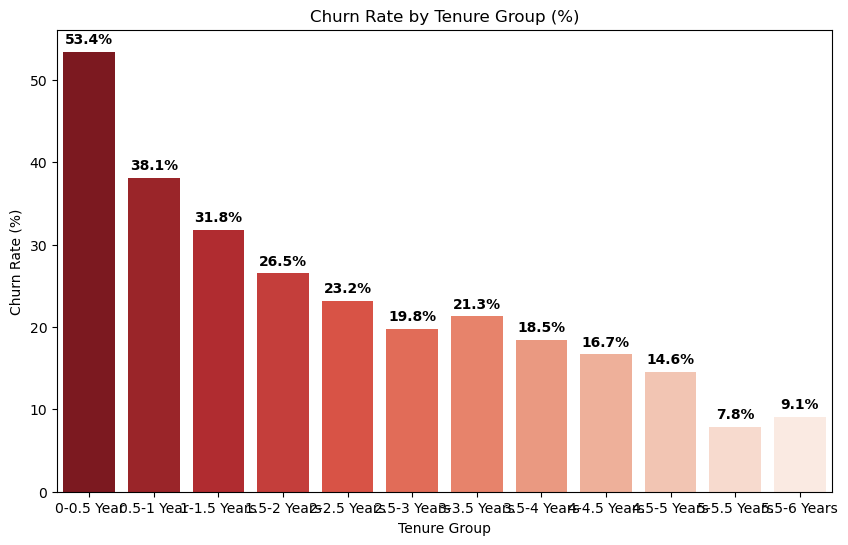

In [16]:
# Visualize churn rate by tenure groups

bins = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]
labels = ['0-0.5 Year', '0.5-1 Year', '1-1.5 Years', '1.5-2 Years', '2-2.5 Years', '2.5-3 Years', '3-3.5 Years', '3.5-4 Years', '4-4.5 Years', '4.5-5 Years', '5-5.5 Years', '5.5-6 Years']
data_copy['TenureGroup'] = pd.cut(data_copy['tenure'], bins=bins, labels=labels, right=False)

churn_by_tenure = data_copy.groupby('TenureGroup')['Churn'].value_counts(normalize=True).unstack()
churn_by_tenure_yes = churn_by_tenure[1] * 100 # 백분율 변환

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_tenure_yes.index, y=churn_by_tenure_yes.values, palette='Reds_r')
plt.title('Churn Rate by Tenure Group (%)')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Tenure Group')

for index, value in enumerate(churn_by_tenure_yes):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', fontweight='bold')

plt.show()

### 이탈(Churn)과 가장 양의 상관관계가 높은 TOP 5 ###
Churn                             1.000000
Contract_Month-to-month           0.406401
OnlineSecurity_No                 0.346382
TechSupport_No                    0.339101
InternetService_Fiber optic       0.312656
PaymentMethod_Electronic check    0.309214
Name: Churn, dtype: float64

### 이탈(Churn)과 가장 음의 상관관계가 높은(이탈을 막는) TOP 5 ###
DeviceProtection_No internet service   -0.228929
StreamingTV_No internet service        -0.228929
StreamingMovies_No internet service    -0.228929
Contract_Two year                      -0.302209
tenure                                 -0.345593
Name: Churn, dtype: float64


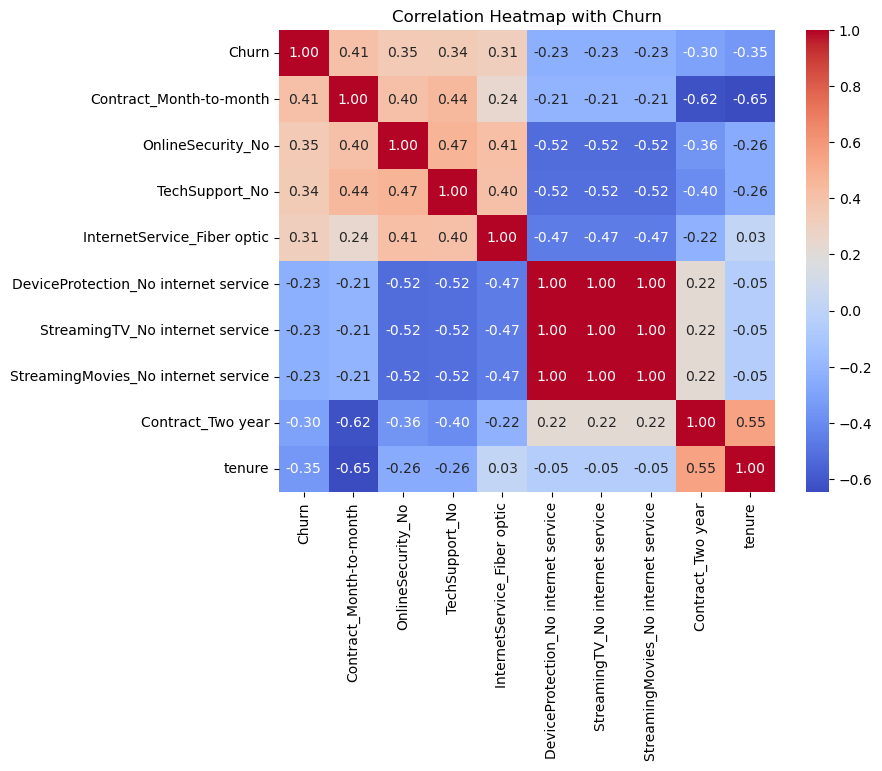

In [17]:
# Correlation analysis between features and Churn

data_corr = data_copy.copy()
df_dummies = pd.get_dummies(data_corr)

correlation = df_dummies.corr()['Churn'].sort_values(ascending=False)

print("### 이탈(Churn)과 가장 양의 상관관계가 높은 TOP 5 ###")
print(correlation.head(6))
print("\n### 이탈(Churn)과 가장 음의 상관관계가 높은(이탈을 막는) TOP 5 ###")
print(correlation.tail(5))

plt.figure(figsize=(8, 6))
important_features = correlation.index[:5].tolist() + correlation.index[-5:].tolist()
sns.heatmap(df_dummies[important_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap with Churn")
plt.show()

In [18]:
# Prepare training and testing datasets

train_X = train_data.drop('Churn', axis=1)
train_y = train_data['Churn'].copy()

test_X = test_data.drop('Churn', axis=1)
test_y = test_data['Churn'].copy()

In [24]:
# Define the custom transformer to simplify service value categories

class ServiceValueSimplifier(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        cols_to_fix = [
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
        ]
        
        for col in cols_to_fix:
            if col in X.columns:
                X[col] = X[col].replace({'No internet service': 'No', 'No phone service': 'No'})
        return X


In [25]:
# Define preprocessing pipelines for categorical and numerical features

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    StandardScaler()
)

In [26]:
# Combine preprocessing pipelines using ColumnTransformer

cat_features = train_X.select_dtypes(include=['object']).columns.tolist()
num_features = ['tenure', 'MonthlyCharges']
log_features = ['TotalCharges']

preprocessor = ColumnTransformer([
    ("cat", cat_pipeline, cat_features),
    ("num", num_pipeline, num_features),
    ("log", log_pipeline, log_features)
])

preprocessor

,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None


In [27]:
# Define the XGBoost classifier

xgb_clf = XGBClassifier(use_label_encoder=False, 
                         eval_metric='aucpr', 
                         random_state=42
                        )

xgb_clf

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [28]:
full_pipeline = Pipeline([
    ("simplifier", ServiceValueSimplifier()),
    ("preprocessing", preprocessor),
    ("XGBClassifier", xgb_clf)
])

full_pipeline

,steps,"[('simplifier', ...), ('preprocessing', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Fitting 10 folds for each of 540 candidates, totalling 5400 fits

최적 파라미터: {'XGBClassifier__learning_rate': 0.01, 'XGBClassifier__max_depth': 3, 'XGBClassifier__n_estimators': 500, 'XGBClassifier__scale_pos_weight': 2, 'XGBClassifier__subsample': 0.6}
최적 F1 점수 (CV 평균): 0.6434


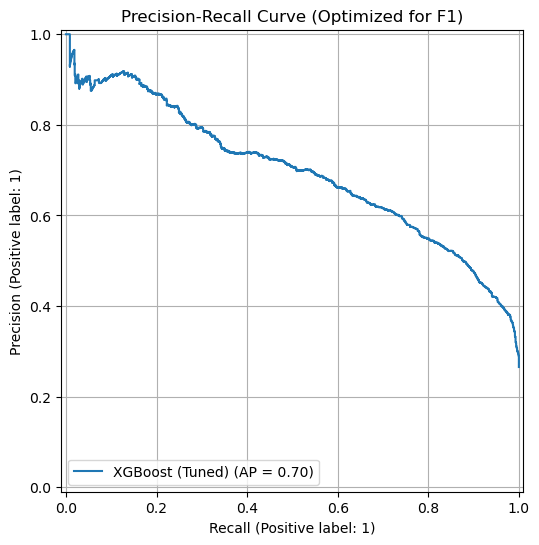

In [29]:
param_grid = [
    {
    'XGBClassifier__n_estimators': [100, 300, 500, 700, 900],
    'XGBClassifier__max_depth': [3, 5, 7, 9],              
    'XGBClassifier__learning_rate': [0.01, 0.1, 0.2],   
    'XGBClassifier__subsample': [0.6, 0.8, 1.0],              
    'XGBClassifier__scale_pos_weight': [1, 2, 3]
    }
]

grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    scoring='f1',  
    cv=10,          
    n_jobs=-1,    
    verbose=1
)

grid_search.fit(train_X, train_y)
best_model = grid_search.best_estimator_

print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최적 F1 점수 (CV 평균): {grid_search.best_score_:.4f}")

fig, ax = plt.subplots(figsize=(8, 6))

display = PrecisionRecallDisplay.from_estimator(
    best_model,
    train_X,
    train_y,
    name="XGBoost (Tuned)",
    ax=ax
)

plt.title("Precision-Recall Curve (Optimized for F1)")
plt.grid(True)
plt.show()

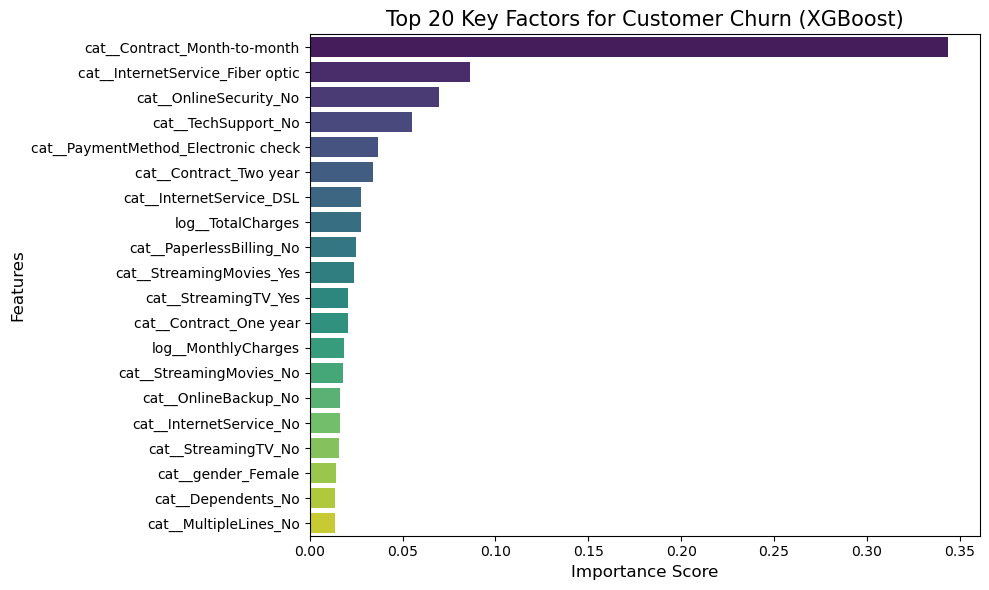

In [ ]:
feature_importances = best_model["XGBClassifier"].feature_importances_
feature_importances.round(2)
feature_names = best_model['preprocessing'].get_feature_names_out()

df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importance.head(20), palette='viridis')

plt.title('Top 20 Key Factors for Customer Churn (XGBoost)', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
pred_y = best_model.predict(test_X)

In [ ]:
print(classification_report(test_y, pred_y, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.89      0.79      0.84      1035
         Yes       0.56      0.74      0.63       374

    accuracy                           0.78      1409
   macro avg       0.72      0.76      0.74      1409
weighted avg       0.80      0.78      0.78      1409



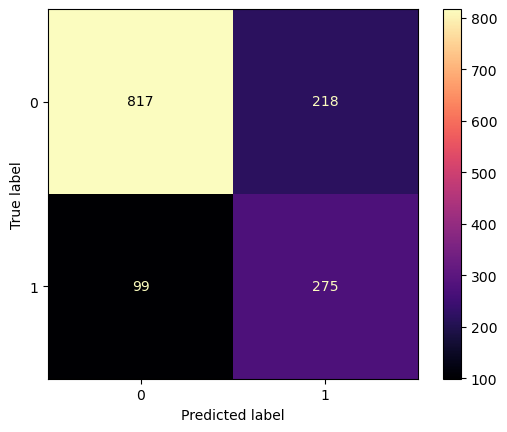

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_y, pred_y, cmap='magma')
plt.show()

In [ ]:

joblib.dump(best_model, "customer_churn_prediction_model.pkl")

['customer_churn_prediction_model.pkl']